# Policy Exploration vs Varying Gamma Value 

In [1]:
import os
import pandas as pd

file_list = []

for txt_file in os.listdir('./txt_files/'):
    if txt_file.startswith('gamma_'):
        file_list.append(txt_file)
        
print file_list[0]

gamma_0.5_epsilon_0.5_ep_decay_0.99_number_of_times_10.txt


In [2]:
# parse the text to find out how reward improves
def parse_text(txt_file):
    with open(txt_file) as f: 
        content = f.readlines()
        
         #data to track
        columns_to_track = ['Trial', 'Gamma', 'Epsilon', 'Epsilon Decay',
                            'Start Location', 'Desination', 'Deadline', 'Total Reward', 'Successful?']
        dframe = pd.DataFrame(columns=columns_to_track) #create empty dataframe

        #build one row of a time looking for columns to track data
        row = []
        main_trial = 0
        for line in content:
            # first line of the txt file 
            if 'Gamma:' in line:
                line_list = line.split(' ') #split on space
                gamma = line_list[1][:-1] # get the gamma value
                epsilon = line_list[3][:-1] # get the epsilon value
                epsilon_decay = line_list[-1].strip() # get the epsilon decay value
                main_trial += 1 # increment main trail (1.1, 1.2....2.1, 2.2.....etc.)
            
            # the start of a new trial 
            if 'Simulator.run()' in line:
                net_reward = 0.0 # reset net reward 
                trial = line[16:].strip() # get trial number
                row.append(trial[:6] + str(main_trial) + '.' + trial[6:]) # splice in main trial
                row.append(gamma)
                row.append(epsilon)
                row.append(epsilon_decay)
                
            # environment initialization 
            if 'Environment.reset(): Trial set' in line:
                row.append(line[47:53].strip()) # get Start location
                row.append(line[69:75].strip()) # get distination
                row.append(int(line[88:91].strip())) # get Deadline
                
            # net reward update 
            if 'Net Reward' in line:
                split_line = line.split(',')
                net_reward = float(split_line[0][11:])
              
            # successful or not successful
            if 'Environment.act()' in line or 'Environment.reset(): Primary' in line:
                row.append(net_reward)
                if 'could not' in line:
                    row.append('No') #Not successful
                else:
                    row.append('Yes') #Successful
                #put in dataframe
                dframe = dframe.append(pd.Series(row, index=columns_to_track), ignore_index=True)
                row = [] #delete row data and start again
            
        return dframe

In [3]:
root_folder = './txt_files/'
dframe_dict = {}

for index, txt_file in enumerate(file_list):
    dframe_dict[index] = parse_text(root_folder + txt_file)
    
dframe_dict[0].head()    

,Trial,Gamma,Epsilon,Epsilon Decay,Start Location,Desination,Deadline,Total Reward,Successful?
0,Trial 1.0,0.5,0.5,0.99,"(6, 5)","(3, 3)",25.0,17.5,No
1,Trial 1.1,0.5,0.5,0.99,"(3, 3)","(7, 3)",20.0,17.0,No
2,Trial 1.2,0.5,0.5,0.99,"(4, 3)","(2, 6)",25.0,27.5,Yes
3,Trial 1.3,0.5,0.5,0.99,"(6, 1)","(5, 6)",30.0,4.5,Yes
4,Trial 1.4,0.5,0.5,0.99,"(2, 2)","(1, 5)",20.0,23.0,No


In [4]:
len(dframe_dict[0][dframe_dict[0]['Successful?'] == 'Yes']) / float(len(dframe_dict[0])) * 100

85.0

In [5]:
def add_if_successful(series, successes):
    for index, value in enumerate(series):
        if successes.iloc[index] == 'Yes':
            series.iloc[index] = value + 10      
    return series 

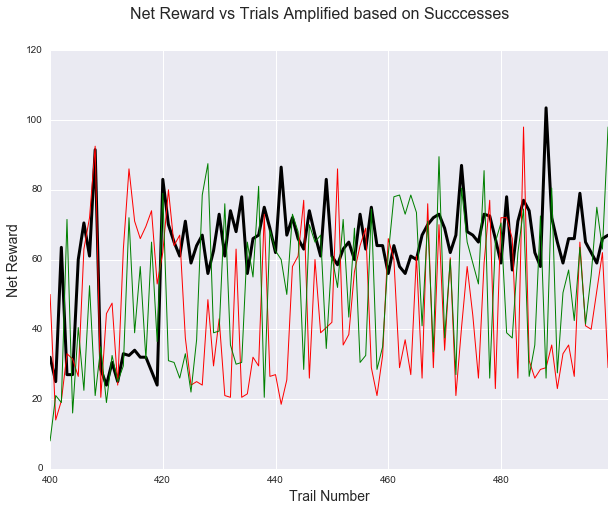

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7.5))
s = 400
e = 500

dframe_0_rewards = dframe_dict[0]['Total Reward'][s:e]
dframe_0_successes = dframe_dict[0]['Successful?'][s:e]
dframe_0_rewards_successes = add_if_successful(dframe_0_rewards, dframe_0_successes)

dframe_1_rewards = dframe_dict[1]['Total Reward'][s:e]
dframe_1_successes = dframe_dict[1]['Successful?'][s:e]
dframe_1_rewards_successes = add_if_successful(dframe_1_rewards, dframe_1_successes)

dframe_2_rewards = dframe_dict[2]['Total Reward'][s:e]
dframe_2_successes = dframe_dict[2]['Successful?'][s:e]
dframe_2_rewards_successes = add_if_successful(dframe_2_rewards, dframe_2_successes)

(dframe_0_rewards_successes).plot(c='k', linewidth=3)
(dframe_1_rewards_successes).plot(c='r', linewidth=1)
(dframe_2_rewards_successes).plot(c='g', linewidth=1, ylim=(0, 120))
plt.suptitle('Net Reward vs Trials Amplified based on Succcesses', fontsize=16)
plt.xlabel('Trail Number', fontsize=14)
plt.ylabel('Net Reward', fontsize=14)
plt.show()